In [3]:
from ddganAE.models import AAE, AAE_combined_loss, CAE, SVDAE
from ddganAE.architectures import *
from ddganAE.preprocessing import convert_2d
from ddganAE.utils import calc_pod
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# POD

This can be used to check against, we try to find models that perform better than POD. Let's use 10 POD components, i.e. 10 latent space dimensions.

In [29]:
snapshots_grids = np.load("./../submodules/DD-GAN/data/processed/snaphsots_field_Velocity_4_1000steps.npy")

coeffs, R = calc_pod(snapshots_grids, nPOD=10)

In [66]:
# Reconstruct the first subgrid
recon = R @ coeffs[0]
print(recon, '\n',
      snapshots_grids[0, :, :])

np.allclose(recon, snapshots_grids[0, :, :], atol=1e-1)

[[ 0.00000000e+00  3.87673888e-02  3.85767394e-02 ...  3.90608055e-02
   3.90439522e-02  3.90469151e-02]
 [ 0.00000000e+00  3.80451672e-02  3.78003913e-02 ...  3.91229868e-02
   3.90873508e-02  3.90166776e-02]
 [ 0.00000000e+00  3.74805025e-02  3.71897893e-02 ...  3.91758150e-02
   3.91317945e-02  3.90005757e-02]
 ...
 [ 0.00000000e+00 -1.84529987e-04 -1.85539152e-04 ...  4.51238956e-04
   1.22883904e-04 -2.52288897e-04]
 [ 0.00000000e+00 -1.28941404e-04 -1.26911436e-04 ...  2.58903926e-04
   1.11626892e-04 -8.40198086e-05]
 [ 0.00000000e+00 -8.18874167e-05 -7.91549017e-05 ...  1.36226552e-04
   7.71317637e-05 -1.54237621e-05]] 
 [[ 0.00000000e+00  3.89666632e-02  3.90002280e-02 ...  3.89970131e-02
   3.89969088e-02  3.89970355e-02]
 [ 0.00000000e+00  3.89941931e-02  3.89987603e-02 ...  3.89979444e-02
   3.89978923e-02  3.89979929e-02]
 [ 0.00000000e+00  3.90042961e-02  3.90013419e-02 ...  3.90015393e-02
   3.90013568e-02  3.90010737e-02]
 ...
 [ 0.00000000e+00  8.37678817e-05 -6.44471

True

In [67]:
print(recon[:, 1],snapshots_grids[0, :, 1])

[ 3.87673888e-02  3.80451672e-02  3.74805025e-02 ... -1.84529987e-04
 -1.28941404e-04 -8.18874167e-05] [3.89666632e-02 3.89941931e-02 3.90042961e-02 ... 8.37678817e-05
 4.94195665e-05 2.91296037e-05]


In [74]:
mean = 0
for i in range(1000):
    mean += tf.keras.losses.MSE(recon[:, i], snapshots_grids[0, :, i]).numpy()/1000
    
print(mean)

5.434973871396598e-07


# Convolutional Autoencoder

### MNIST sanity check

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.0003, beta_1=0.9, beta_2=0.999)

input_shape = (28, 28, 1)

encoder, decoder = build_mnist_wide_omata_encoder_decoder(input_shape, 10, initializer, info=True)

cae = CAE(encoder, decoder, optimizer)
cae.compile(input_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

In [4]:
cae.train(x_train, 200, x_test, plot_loss=True, batch_size=1000)

NameError: name 'x_train' is not defined

### Our dataset (55x42)

In [5]:
# Data processing
snapshots_grids = np.load("./../submodules/DD-GAN/data/processed/snaphsots_field_Velocity_4_1000steps.npy")

input_shape = (55, 42, 2)
snapshots = convert_2d(snapshots_grids, input_shape, 1000)
snapshots = np.array(snapshots).reshape(4000, *input_shape)
snapshots.shape


from sklearn.model_selection import train_test_split

x_train, x_val = train_test_split(snapshots, test_size=0.1)

In [6]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

encoder, decoder = build_wider_omata_encoder_decoder(input_shape, 10, initializer, info=True)

cae = CAE(encoder, decoder, optimizer)
cae.compile(input_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 42, 16)        816       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 21, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 21, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2688)              0

In [ ]:
cae.train(x_train, 300, val_data=x_val)

4/4 [==============================] - 0s 62ms/step - loss: 1.5697e-05 - accuracy: 0.9958


1/1 [==============================] - 0s 113ms/step - loss: 8.2153e-06 - accuracy: 0.9964


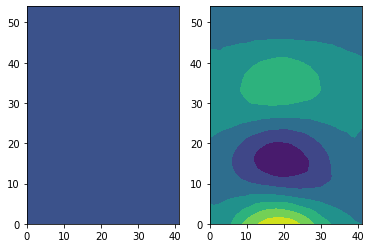

In [5]:
grid = x_train[2010:2011, :, :, :]
res = cae.predict(grid)

fig, ax = plt.subplots(1,2)
ax[0].contourf(res[0,:,:,1])
ax[1].contourf(grid[0, :, :, 1])

### Our dataset (221x42)

In [2]:
# Data processing
snapshots_grids = np.load("./../submodules/DD-GAN/data/processed/snaphsots_field_Velocity_1_1000steps.npy")

input_shape = (221, 42, 2)
snapshots = convert_2d(snapshots_grids, input_shape, 1000)
snapshots = np.array(snapshots).reshape(1000, *input_shape)
print(snapshots.shape)

from sklearn.model_selection import train_test_split

x_train, x_val = train_test_split(snapshots, test_size=0.1)

(1000, 221, 42, 2)


In [3]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999)

encoder, decoder = build_agostini_encoder_decoder(input_shape, 10, initializer, info=True)

cae = CAE(encoder, decoder, optimizer)
cae.compile(input_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 221, 42, 16)       816       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 21, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 111, 21, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 6, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 10752)             0

In [7]:
cae.train(x_train, 200, x_val, plot_loss=True, print_loss=True)

TypeError: train() got an unexpected keyword argument 'plot_loss'

# Adversarial Autoencoder

In [4]:
# Data processing
snapshots_grids = np.load("./../submodules/DD-GAN/data/processed/snaphsots_field_Velocity_4_1000steps.npy")

input_shape = (55, 42, 2)
snapshots = convert_2d(snapshots_grids, input_shape, 1000)
snapshots = np.array(snapshots).reshape(4000, *input_shape)
snapshots.shape

from sklearn.model_selection import train_test_split

x_train, x_val = train_test_split(snapshots, test_size=0.1)

In [5]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999)

encoder, decoder = build_wider_omata_encoder_decoder(input_shape, 10, initializer, info=True)
discriminator = build_custom_discriminator(10, initializer, info=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 42, 16)        816       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 21, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 21, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2688)              0

### Separate losses

In [6]:
aae = AAE(encoder, decoder, discriminator, optimizer)
aae.compile(input_shape)
aae.train(x_train, 100, val_data=x_val)

4/4 [==============================] - 0s 9ms/step - loss: 0.5901 - accuracy: 0.8047


4/4 [==============================] - 0s 38ms/step - loss: 0.7989 - accuracy: 0.0000e+00


4/4 [==============================] - 0s 1ms/step - loss: 0.7659 - accuracy: 0.2266


4/4 [==============================] - 0s 22ms/step - loss: 0.7398 - accuracy: 0.0000e+00


4/4 [==============================] - 0s 2ms/step - loss: 0.6798 - accuracy: 0.5391


4/4 [==============================] - 0s 1ms/step - loss: 0.8296 - accuracy: 0.0000e+00


4/4 [==============================] - 0s 36ms/step - loss: 6.9720e-04 - accuracy: 0.9896


4/4 [==============================] - 0s 9ms/step - loss: 0.6647 - accuracy: 0.6641


4/4 [==============================] - 0s 6ms/step - loss: 0.6391 - accuracy: 1.0000


4/4 [==============================] - 0s 42ms/step - loss: 0.7410 - accuracy: 0.0000e+00


4/4 [==============================] - 0s 32ms/step - loss: 5.2762e-04 - accuracy: 0.9918


4/4 [==============================] - 0s 10ms/step - loss: 0.7006 - accuracy: 0.5391


4/4 [==============================] - 0s 40ms/step - loss: 0.6826 - accuracy: 1.0000


### Combined losses

In [4]:
aae = AAE_combined_loss(encoder, decoder, discriminator, optimizer)
aae.compile(input_shape)
aae.train(snapshots, 100, val_data=x_val)

4/4 [==============================] - 0s 13ms/step - loss: 0.2309 - accuracy: 1.0000


4/4 [==============================] - 0s 45ms/step - loss: 0.0036 - sequential_1_loss: 8.3624e-04 - sequential_2_loss: 2.7681


4/4 [==============================] - 0s 6ms/step - loss: 0.0994 - accuracy: 1.0000


4/4 [==============================] - 0s 14ms/step - loss: 0.0013 - sequential_1_loss: 2.4902e-04 - sequential_2_loss: 1.0431


KeyboardInterrupt: 

# SVD Autoencoder

In [2]:
# Data processing
snapshots_grids = np.load("./../submodules/DD-GAN/data/processed/snaphsots_field_Velocity_4_1000steps.npy")

In [3]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.0003, beta_1=0.9, beta_2=0.999)

dense_encoder = build_dense_encoder(10, initializer, info=False)
dense_decoder = build_dense_decoder(100, 10, initializer, info=False)

svdae = SVDAE(dense_encoder, dense_decoder, optimizer)
svdae.compile(100)

In [4]:
svdae.train(snapshots_grids, 20, val_data=snapshots_grids)

4/4 [==============================] - 0s 28ms/step - loss: 0.0092 - accuracy: 1.0000


4/4 [==============================] - 0s 3ms/step - loss: 0.0096 - accuracy: 1.0000


4/4 [==============================] - 0s 19ms/step - loss: 0.0093 - accuracy: 1.0000


4/4 [==============================] - 0s 6ms/step - loss: 0.0090 - accuracy: 1.0000


4/4 [==============================] - 0s 12ms/step - loss: 0.0091 - accuracy: 1.0000


4/4 [==============================] - 0s 3ms/step - loss: 0.0091 - accuracy: 1.0000


1/1 [==============================] - 0s 81ms/step - loss: 0.0091 - accuracy: 1.0000


In [10]:
result = aae.autoencoder.predict(x_train[0:1, :, :, :])

In [19]:
result.shape

(1, 55, 42, 2)

In [13]:
x_train[0:1, :, :, :]

array([[[[0.03923248, 0.03276334],
         [0.02745112, 0.02499096],
         [0.02740092, 0.03278   ],
         ...,
         [0.04790778, 0.04183141],
         [0.03613279, 0.03226997],
         [0.02850322, 0.0281944 ]],

        [[0.03263314, 0.03807206],
         [0.04312166, 0.04758514],
         [0.04697782, 0.04088504],
         ...,
         [0.02776872, 0.03162317],
         [0.03710828, 0.04216704],
         [0.04694416, 0.04767733]],

        [[0.04206504, 0.03631629],
         [0.03251242, 0.02887829],
         [0.02816894, 0.03251033],
         ...,
         [0.04811027, 0.04326758],
         [0.03721172, 0.03317336],
         [0.02945842, 0.02786435]],

        ...,

        [[0.03509371, 0.03341153],
         [0.03156368, 0.03314099],
         [0.03695046, 0.04024545],
         ...,
         [0.03357967, 0.03507147],
         [0.03388926, 0.0317143 ],
         [0.03253385, 0.03628625]],

        [[0.03972154, 0.04137981],
         [0.03866563, 0.03488437],
         [0.

In [15]:
import matplotlib.pyplot as plt

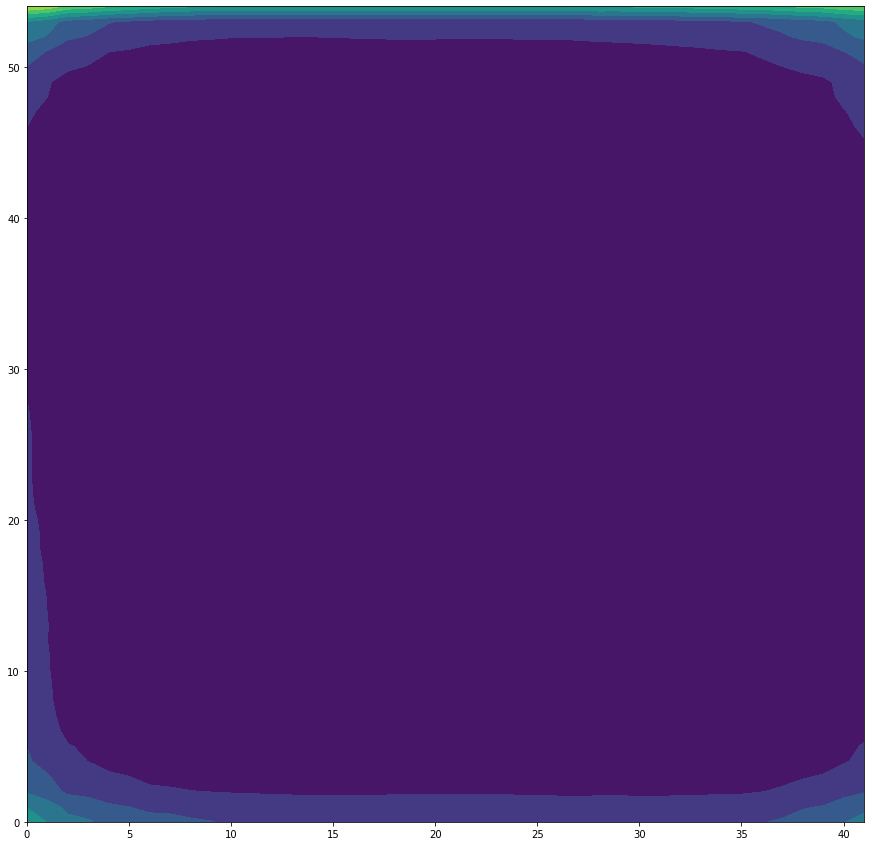

In [28]:
fig, ax = plt.subplots(1, figsize=(15,15))
ax.contourf(result[0, :, :, 0])

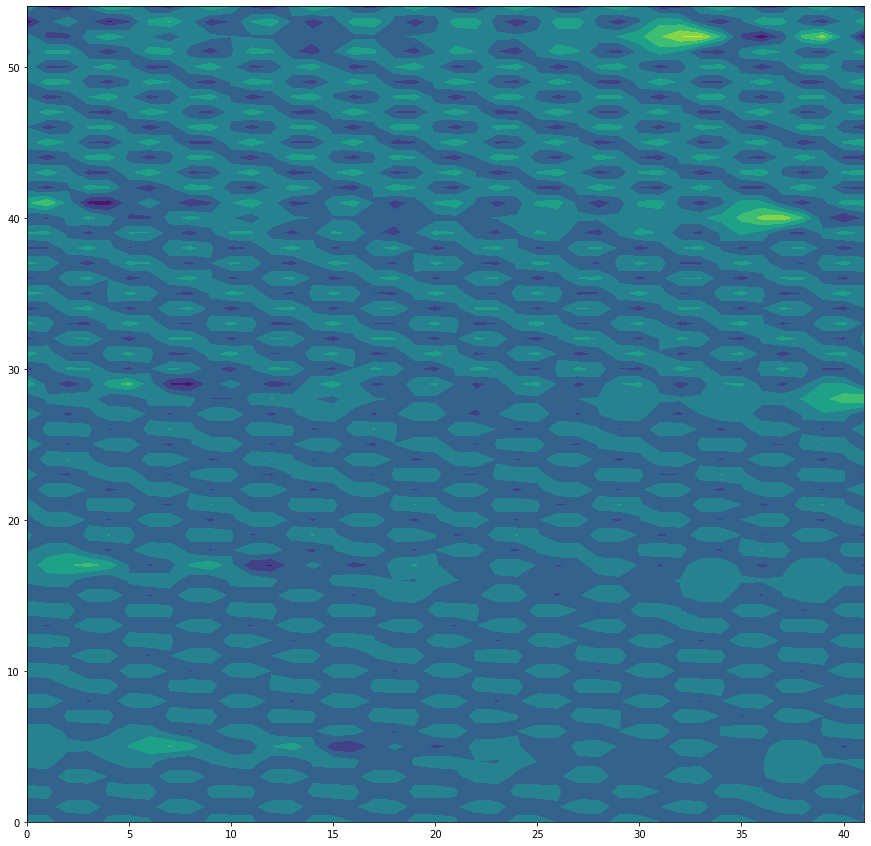

In [26]:
fig, ax = plt.subplots(1, figsize=(15,15))
ax.contourf(x_train[110, :, :, 0])

(2, 55, 42, 1000)
(55, 42, 2, 1000)


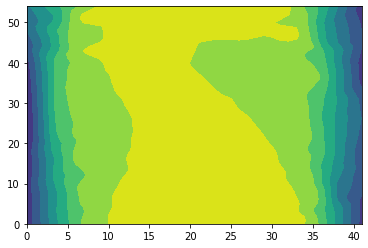

In [129]:
snap = snapshots_grids[3, :, :].reshape(2, 55,42, snapshots_grids.shape[-1])
print(snap.shape)
snap = np.moveaxis(snap, 0, 2)
print(snap.shape)
fig, ax = plt.subplots()
ax.contourf(snap[:, :, 0, 11])

In [131]:
snap = np.moveaxis(snap, 3, 0)

In [135]:
snap.shape

(1000, 55, 42, 2)

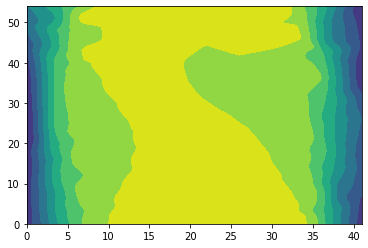

In [134]:
fig, ax = plt.subplots()
ax.contourf(snap[10, :, :, 0])

In [97]:
for i in snapshots_grids:
    print(i.shape)

(4620, 1000)
(4620, 1000)
(4620, 1000)
(4620, 1000)


In [11]:
snapshots_grids = np.load("./../submodules/DD-GAN/data/processed/snaphsots_field_Velocity_4_1000steps.npy")

input_shape = (55, 42, 2)
snapshots = convert_2d(snapshots_grids, input_shape, 1000)
snapshots = np.array(snapshots).reshape(4000, *input_shape)

In [12]:
snapshots.shape

(4000, 55, 42, 2)

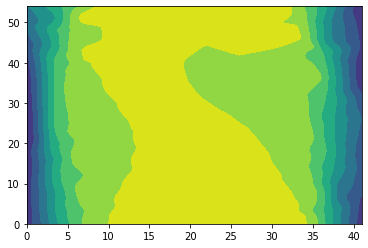

In [21]:
fig, ax = plt.subplots(1)
ax.contourf(snapshots[3010,:,:,0])